# EM estimate vs direct optimization issue

Here I compare EM with `optim` in a larger simulated data-set involving 50 conditions. Example below is when `EM` and `optim` results are different and `optim` result seems better.

In [7]:
dat = readRDS('lite_data_1_artificial_mixture_1_mnm_shared_1.rds')

In [8]:
## r script UUID: 14676992
library(mmbr)
library(flashier)
DSC_A8484812 <- list()
DSC_A8484812 <- dscrutils:::load_inputs(c('lite_data_1.rds','lite_data_1_artificial_mixture_1.rds'), dscrutils:::read_dsc)
DSC_REPLICATE <- DSC_A8484812$DSC_DEBUG$replicate
X <- DSC_A8484812$X
Y <- DSC_A8484812$Y
meta <- DSC_A8484812$meta
eff_mode <- 'shared'
L <- 10
resid_method <- 'oracle'
TIC_A8484812 <- proc.time()
set.seed(DSC_REPLICATE)

## BEGIN DSC CORE
get_center <- function(k,n) {
  if (is.null(k)) {
      return(1:n)
  }
  start = floor(n/2 - k/2)
  end = floor(n/2 + k/2)
  if (start<1) start = 1
  if (end>n) end = n
  return(start:end)
}
center_scale <- function(X) return(susieR:::set_X_attributes(as.matrix(X), center=TRUE, scale = TRUE))
subset_N <- function(gene, N_sub){
    if(!is.null(N_sub)){
        Ntot <- nrow(gene$X)
        to_keep <- sort(sample(x=c(1:Ntot), size=N_sub, replace=F))
        gene$X <- gene$X[to_keep, ]
        gene$y <- gene$y[to_keep]
        gene$Z <- gene$Z[to_keep, ]
        return(gene)
    } else { ###If we don't want to subset individuals
        return(gene)
    }
}
compute_cov_diag <- function(Y){
    covar <- diag(apply(Y, 2, var, na.rm=T))
    return(covar)
}
compute_cov_flash <- function(Y){
    fl <- flashier::flash(Y, var.type = 2, prior.family = c(flashier::prior.normal(), flashier::prior.normal.scale.mix()), backfit = TRUE, verbose.lvl=0)
    if(fl$n.factors==0){
      covar <- diag(fl$residuals.sd^2)
    } else {
      fsd <- sapply(fl$fitted.g[[1]], '[[', "sd")
      covar <- diag(fl$residuals.sd^2) + crossprod(t(fl$flash.fit$EF[[2]]) * fsd)
    }
    s <- diag(apply(Y, 2, sd, na.rm=T))
    covar <- s%*%cov2cor(covar)%*%s
    return(covar)
}
create_missing <- function(Y1, Y0) {
    if (ncol(Y0) < ncol(Y1)) {
        for (i in 1:(ncol(Y1) - ncol(Y0))) {
            Y0 = cbind(Y0, sample(Y0[, sample.int(ncol(Y0), size=1)]))
        }
    }
    if (ncol(Y0) > ncol(Y1)) Y0 = Y0[,sample(1:ncol(Y1))]
    res = Y1
    res[which(is.na(Y0))] = NA
    na_rows = which(apply(res, 1, function(x) all(is.na(x))))
    for (i in na_rows) {
	    non_na = sample.int(ncol(res), size=1)
        res[i,non_na] = Y1[i,non_na]
    }
    return(res)
}
compute_maf <- function(geno){
   f <- mean(geno,na.rm = TRUE)/2
   return(min(f, 1-f))
}
compute_missing <- function(geno){
  miss <- sum(is.na(geno))/length(geno)
  return(miss)
}
mean_impute <- function(geno){
  f <- apply(geno, 2, function(x) mean(x,na.rm = TRUE))
  for (i in 1:length(f)) geno[,i][which(is.na(geno[,i]))] <- f[i]
  return(geno)
}
is_zero_variance <- function(x) {
  if (length(unique(x))==1) return(T)
  else return(F)
}
filter_X <- function(X, missing_rate_thresh, maf_thresh) {
    rm_col <- which(apply(X, 2, compute_missing) > missing_rate_thresh)
    if (length(rm_col)) X <- X[, -rm_col]
    rm_col <- which(apply(X, 2, compute_maf) < maf_thresh)
    if (length(rm_col)) X <- X[, -rm_col]
    rm_col <- which(apply(X, 2, is_zero_variance))
    if (length(rm_col)) X <- X[, -rm_col]
    return(mean_impute(X))
}
prior = meta$prior[[eff_mode]]
if (is.null(prior)) {
    prior = list(xUlist = mmbr:::create_cov_canonical(ncol(Y)))
}
if (resid_method == 'flash') {
    resid_Y <- compute_cov_flash(Y)
} else if (resid_method == 'diag') {
    resid_Y <- compute_cov_diag(Y)
} else {
    resid_Y <- meta$residual_variance
}

Script to load simulated data and generate the result is available via `cat(dat$DSC_DEBUG$script)`. Simply copy that code and run the data generation; then run the analysis using `EM` and `optim`.

## EM result

In [25]:
result = msusie(X, Y, L=L, prior_variance=matrix(1,50,50), residual_variance=resid_Y, compute_objective=T, estimate_residual_variance=F, estimate_prior_variance=T, 
                estimate_prior_method='EM', track_fit=T, precompute_covariances=F)

Loading mmbr



In [26]:
result$V

[1] 0.1331901 0.1331220 0.1327980 0.1326600 0.1326339 0.0000000 0.0000000
 [8] 0.0000000 0.0000000 0.0000000

It seems the prior estimate are consistantly large for all effects. This data-set has 3 simulated signals,

In [3]:
which(rowSums(meta$true_coef) != 0)

[1]  43 129 162

In [4]:
meta$true_coef[which(rowSums(meta$true_coef) != 0),]

0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,1.05848305,⋯,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
-0.4515795,0.2123624,-0.2313993,1.2908204,-0.1391929,0.4586080,1.1908100,0.5195072,-0.444041,0.55288239,⋯,0.8074542,1.1655001,0.55635426,0.4118661,-0.4539847,-0.3545635,0.5953944,-0.7013678,1.0421826,1.2604212
-0.7054777,-0.7788946,-0.6342108,0.7883361,-0.7436080,0.0631215,-0.7432346,-0.1296268,-1.130015,0.05221385,⋯,-0.7423689,0.5043965,0.01963459,-0.4722924,-0.2650975,-0.7530046,-0.9196253,-0.1616042,-0.2687143,-0.8154856


Clearly this will not fit a model of "all shared" effects.

Using "all shared" prior we have captured 4 effects with non-zero PIP, 2 of them are real.

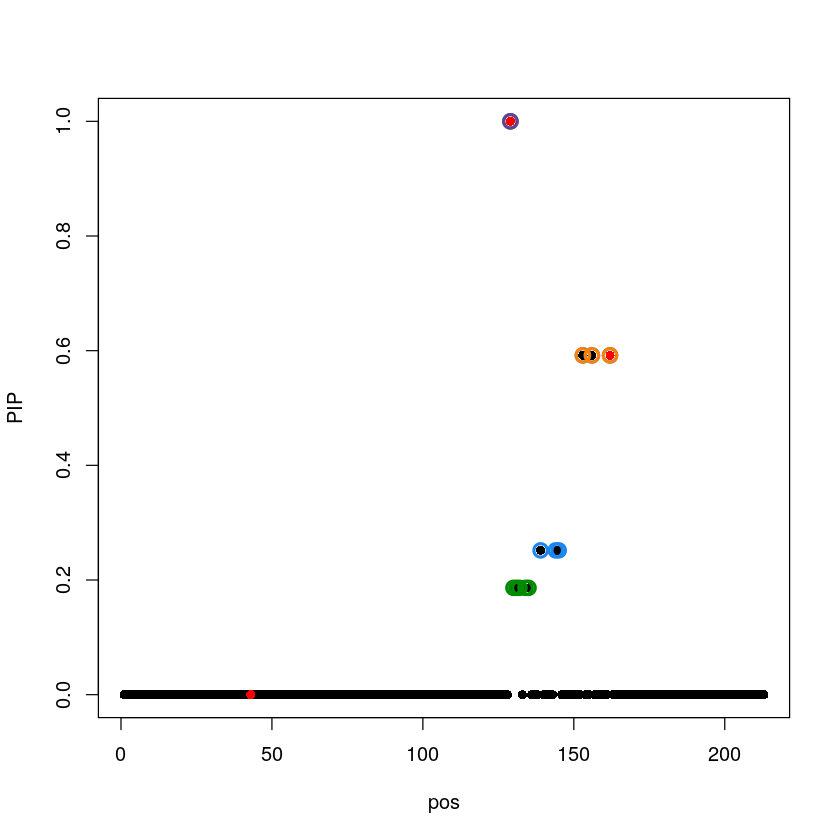

In [28]:
susieR::susie_plot(result, y='PIP',b=rowSums(meta$true_coef))

In [21]:
result$sets

,min.abs.corr,mean.abs.corr,median.abs.corr
,<dbl>,<dbl>,<dbl>
L1,1.0000000,1.0000000,1.0000000
L2,1.0000000,1.0000000,1.0000000
L4,0.9845723,0.9957145,1.0000000
L5,0.9601872,0.9800936,0.9800936


From single effect CS result, `L4` contains `L2` and `L5` contains `L1`. As a result both `L4` and `L5` appear to contain a true signals. Because of overlap between `L1` and `L5`, the 3 variables in `L1` (orange) appears to have marginal PIP 0.6 rather than 0.3. Both `L4` and `L5` have high purity.

In [12]:
result$alpha[,c(153,156,162)]

3.333333e-01,3.333333e-01,3.333333e-01
6.349176e-142,6.349176e-142,6.349176e-142
3.333311e-01,3.333311e-01,3.333311e-01
1.788361e-11,1.788361e-11,1.788361e-11
8.156961e-02,8.156961e-02,8.156961e-02
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03


In [13]:
result$pip[c(153,156,162)]

[1] 0.5918074 0.5918074 0.5918074

Looking into the effect size,

In [17]:
result$coef[130,]

[1] 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508
 [8] 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508
[15] 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508
[22] 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508
[29] 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508
[36] 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508
[43] 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508
[50] 0.1276508

In [33]:
meta$true_coef[129,]

[1] -0.45157952  0.21236242 -0.23139926  1.29082045 -0.13919288  0.45860797
 [7]  1.19081005  0.51950718 -0.44404096  0.55288239  1.02044255 -0.67181462
[13]  0.64829538  0.90472892  0.56318766 -0.38077228  0.34985535 -0.33371293
[19]  0.35185973  0.07553337  1.74655110  0.13276429  0.79027876  1.74287184
[25] -0.35777077 -0.06698781  0.98438493  1.34967008  0.65389743  0.28627559
[31]  0.37316311  0.72586052  0.45548786  1.25877288  0.38942776 -0.53494513
[37]  0.17705649 -0.40382396  0.01924867 -0.15283342  0.80745418  1.16550010
[43]  0.55635426  0.41186611 -0.45398470 -0.35456347  0.59539439 -0.70136776
[49]  1.04218255  1.26042124

and 2nd moment of the estimated effect size, 

In [19]:
tcrossprod(result$coef[130,])[1,1]

[1] 0.01629244

In [16]:
sum(diag(tcrossprod(result$coef[130,])))/50

[1] 0.01629244

So the estimated `V` should be about this scale for the first effect.

In [24]:
result$coef[result$sets$cs$L4+1,]

0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,⋯,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810
0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,⋯,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951
0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,⋯,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951
0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,⋯,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951
0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,⋯,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951
0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,⋯,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951


## `optim` result

It takes long time to compute, but the PIP is cleaner. The estimated prior scalar is also smaller.

In [8]:
result2 = msusie(X, Y, L=L, prior_variance=matrix(1,50,50), residual_variance=resid_Y, compute_objective=T, estimate_residual_variance=F, estimate_prior_variance=T, 
                estimate_prior_method='optim', track_fit=T, precompute_covariances=F)

In [9]:
result2$V

[1] 0.0007557952 0.0009296375 0.0002614547 0.0000000000 0.0000000000
 [6] 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000

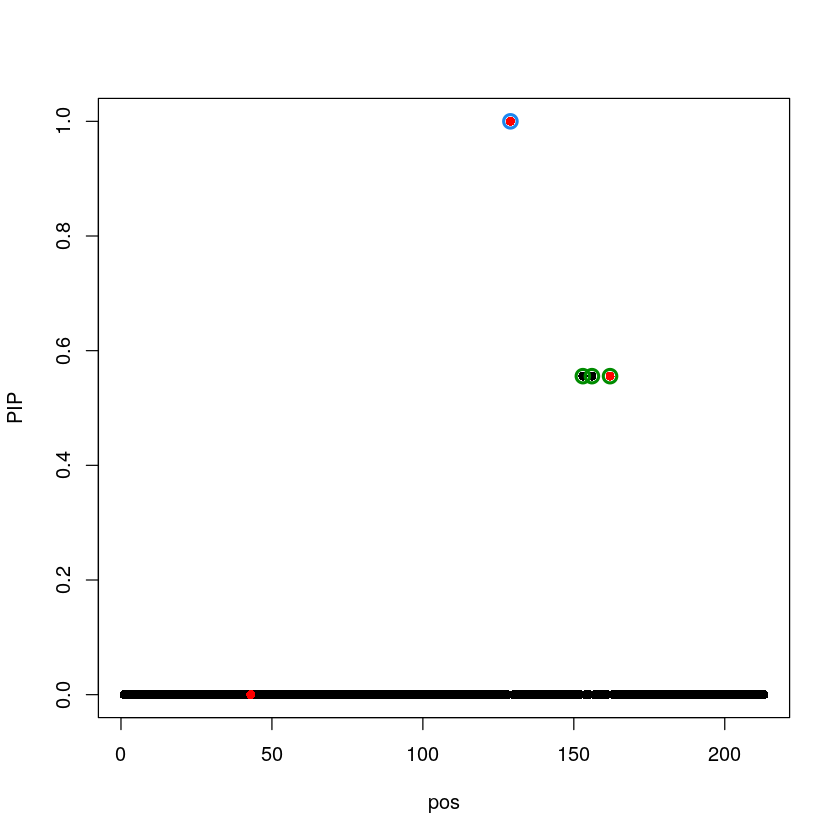

In [10]:
susieR::susie_plot(result2, y='PIP', b=rowSums(meta$true_coef))

In [20]:
result2$sets

,min.abs.corr,mean.abs.corr,median.abs.corr
,<dbl>,<dbl>,<dbl>
L1,1,1,1
L2,1,1,1


In [18]:
result2$alpha[,c(153,156,162)]

3.333333e-01,3.333333e-01,3.333333e-01
1.447861e-221,1.447861e-221,1.447861e-221
3.332946e-01,3.332946e-01,3.332946e-01
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03


It seems to have the same issue that the first and the 3rd effects are overlapping. But because they are identical CS, we only kept one of them. 

In [28]:
susieR::susie_get_cs(result2, dedup=F)

$cs
$cs$L1
[1] 153 156 162

$cs$L2
[1] 129

$cs$L3
[1] 153 156 162


$coverage
[1] 0.95

However **such duplicate is not adjusted for when computing PIP**. This is why PIP for those 3 variables still sum to more than 1.

In [19]:
result2$pip[c(153,156,162)]

[1] 0.5555297 0.5555297 0.5555297

In [20]:
result2$coef[130,]

[1] 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662
[10] 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662
[19] 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662
[28] 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662
[37] 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662
[46] 0.15662 0.15662 0.15662 0.15662 0.15662

The estimated `V` is expected to roughly have the scale of

In [29]:
sum(diag(tcrossprod(result2$coef[130,])))/50

[1] 0.02452981

But the actual `V` is a lot smaller.

## Analysis using naive canonical mixture prior

The example is a bit pathological because we knowingly use a wrong model for it. What if we use a more flexible MASH prior for it? Here I use canonical mixture with uniform weights,

In [35]:
prior = list(xUlist = mmbr:::create_cov_canonical(ncol(Y)))
m_init = create_mash_prior(mixture_prior = list(matrices=prior$xUlist, weights=prior$pi), null_weight=prior$null_weight, max_mixture_len=-1)
result3 = msusie(X, Y, L=L, prior_variance=m_init, residual_variance=resid_Y, 
                 compute_objective=T, estimate_residual_variance=F, estimate_prior_variance=T, 
                 estimate_prior_method='EM', track_fit=T, precompute_covariances=T)

In [36]:
result3$V

[1] 0.0573641369 0.0114649642 0.0002619859 0.3738287539 0.0000000000
 [6] 0.1326584581 0.0000000000 0.0000000000 0.0000000000 0.0000000000

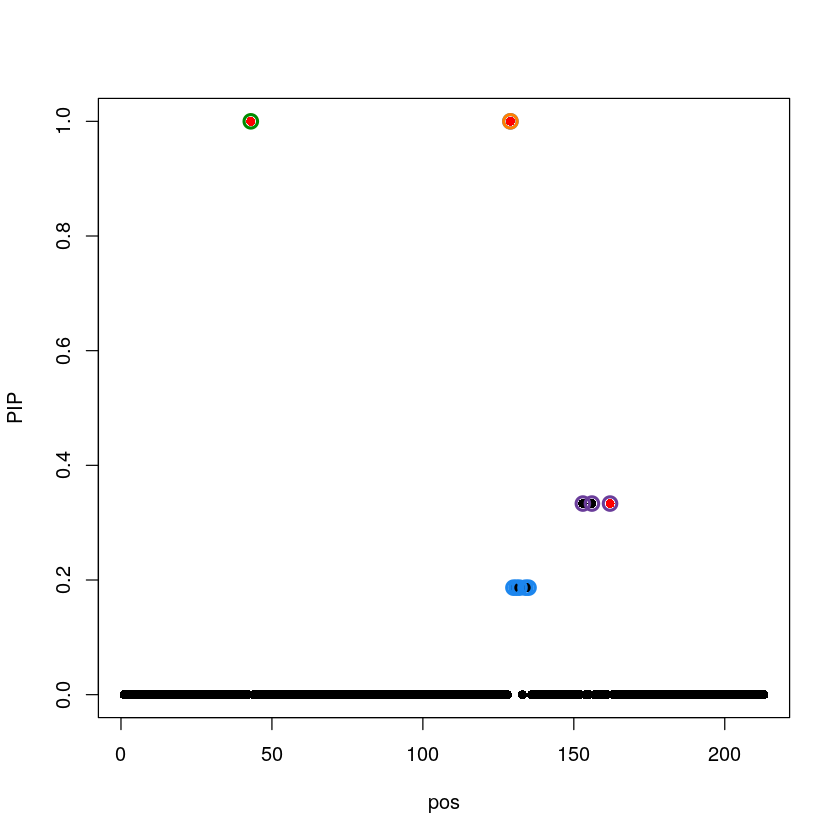

In [37]:
susieR::susie_plot(result3, y='PIP',b=rowSums(meta$true_coef))

In [38]:
result3$sets

,min.abs.corr,mean.abs.corr,median.abs.corr
,<dbl>,<dbl>,<dbl>
L1,1.0000000,1.0000000,1
L2,1.0000000,1.0000000,1
L4,1.0000000,1.0000000,1
L6,0.9845723,0.9957145,1


The result is a bit better. We have now captured all 3 variables -- the new variable in `L4` is a singleton effect.

In [41]:
max(result3$coef[44,])

[1] 1.106003

In [42]:
min(result3$coef[44,])

[1] -8.202458e-12

But there is still overlap between `L6` and `L1`, even though `L6` indeed does contain a signal. And estimated prior scalar for the 6th variable is again the magic number 0.13. Notice the purity for `L6` is quite high as we would also conclude from the plot.

## What if we use oracle mixture?

The data is simulated using `artificial_mixture`. Here I'll analyze it with the same mixture prior structure and weight, but using EM to estimate the scale.

In [45]:
names(meta$prior$oracle)

[1] "xUlist"      "pi"          "null_weight"

In [46]:
m_init = create_mash_prior(mixture_prior = list(matrices=meta$prior$oracle$xUlist, weights=meta$prior$oracle$pi), null_weight=meta$prior$oracle$null_weight, max_mixture_len=-1)
result4 = msusie(X, Y, L=L, prior_variance=m_init, residual_variance=resid_Y, 
                 compute_objective=T, estimate_residual_variance=F, estimate_prior_variance=T, 
                 estimate_prior_method='EM', track_fit=T, precompute_covariances=T)

In [47]:
result4$V

[1] 0.0573683484 0.0114170111 0.0002651896 0.3738270414 0.0000000000
 [6] 0.1299527025 0.0000000000 0.0000000000 0.0000000000 0.0000000000

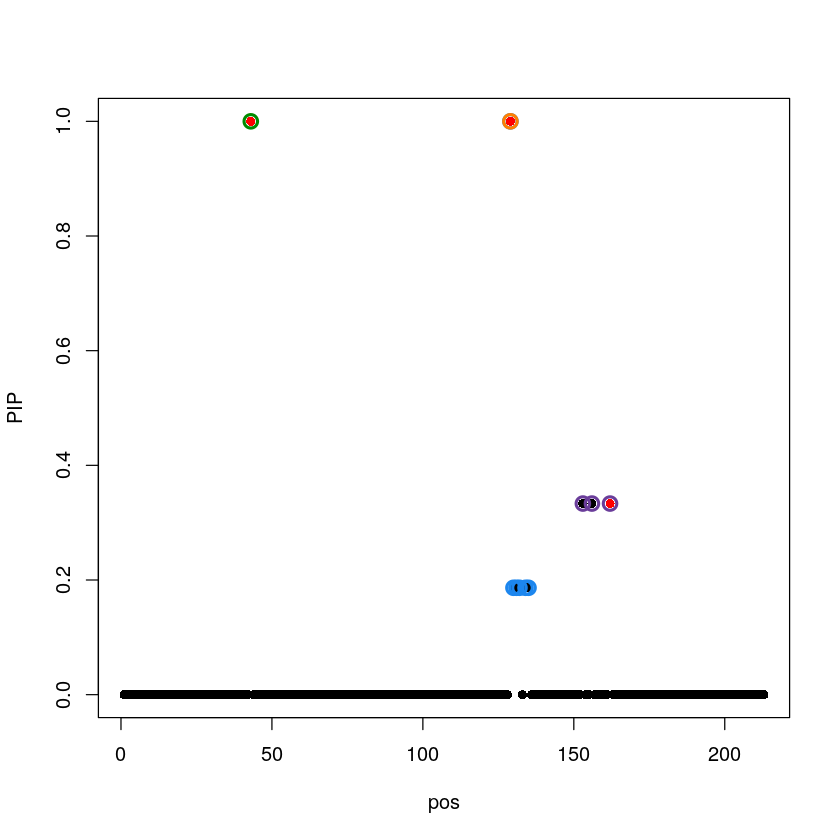

In [48]:
susieR::susie_plot(result4, y='PIP',b=rowSums(meta$true_coef))

In [49]:
result4$sets

,min.abs.corr,mean.abs.corr,median.abs.corr
,<dbl>,<dbl>,<dbl>
L1,1.0000000,1.0000000,1
L2,1.0000000,1.0000000,1
L4,1.0000000,1.0000000,1
L6,0.9845723,0.9957145,1


Unfortunately, oracle prior does not help here.